<a href="https://colab.research.google.com/github/octavioeac/LLM-AZ/blob/main/prototype_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## "SparseHeadClassifier: Multi-Sparse Attention Transformer for Text Quality Classification in Technical QA Descriptions"

# Abstract:
In this work, we introduce SparseHeadClassifier, a Transformer-based architecture designed for evaluating the quality of textual descriptions in technical QA environments such as JIRA. Our model leverages a novel multi-sparse attention mechanism, where each attention head applies a distinct sparsity strategy—such as top-k, local, or full attention—allowing the model to capture diverse contextual patterns efficiently. Each attention head is followed by a dimensionality-reducing compression step before concatenation, improving computational efficiency and preserving salient features. The final classification layer outputs a quality score (Good, Regular, or Poor), enabling automated evaluation of QA documentation. Experiments show that the SparseHeadClassifier balances expressiveness and efficiency, and can serve as a robust tool for assessing the consistency and clarity of issue tracking text data in real-world software projects. *texto en cursiva*

SparseHeadClassifier is a Transformer model that automatically analyzes text descriptions from platforms like JIRA and classifies them as Good, Regular, or Poor. What makes it unique is that each attention head uses a different sparsity strategy—some focus only on the top-k important tokens, others look at nearby tokens, and some attend fully. This gives the model a richer view of the text while being more efficient. Each head compresses its output, and then everything is passed to a neural network that makes the final quality prediction. It's ideal for identifying low-quality, inconsistent, or vague bug or test descriptions in software teams.

## Architecture Explanation
SparseHeadClassifier is a Transformer-based architecture designed to assess the quality of technical descriptions, such as those written in JIRA for software testing. Its goal is to automatically classify each description as Good, Regular, or Poor.

The architecture consists of the following components:

Tokenization and Positional Embedding
The input text is converted into numerical vectors, enriched with positional information to retain word order.

Sparse Multi-Head Attention Layer
Each attention head applies a different sparsity strategy, such as:

Top-k: focuses only on the most relevant tokens.

Local: attends to neighboring tokens within a window.

Full: attends to all tokens.

This allows the model to efficiently capture both local and global contextual patterns.

Per-Head Compression
Each attention head applies a linear projection to compress its output, reducing dimensionality while preserving key information. This improves efficiency and scalability.

Concatenation and Final Projection
The compressed outputs are concatenated and passed through a linear layer to unify dimensions.

Aggregation and Classification
The result is aggregated (via mean pooling or a [CLS] token) and passed to a feedforward classifier that predicts the text quality level: Good, Regular, or Poor.

This architecture enables automatic, efficient, and accurate evaluation of QA-related technical descriptions, helping software teams maintain clarity and consistency in documentation.

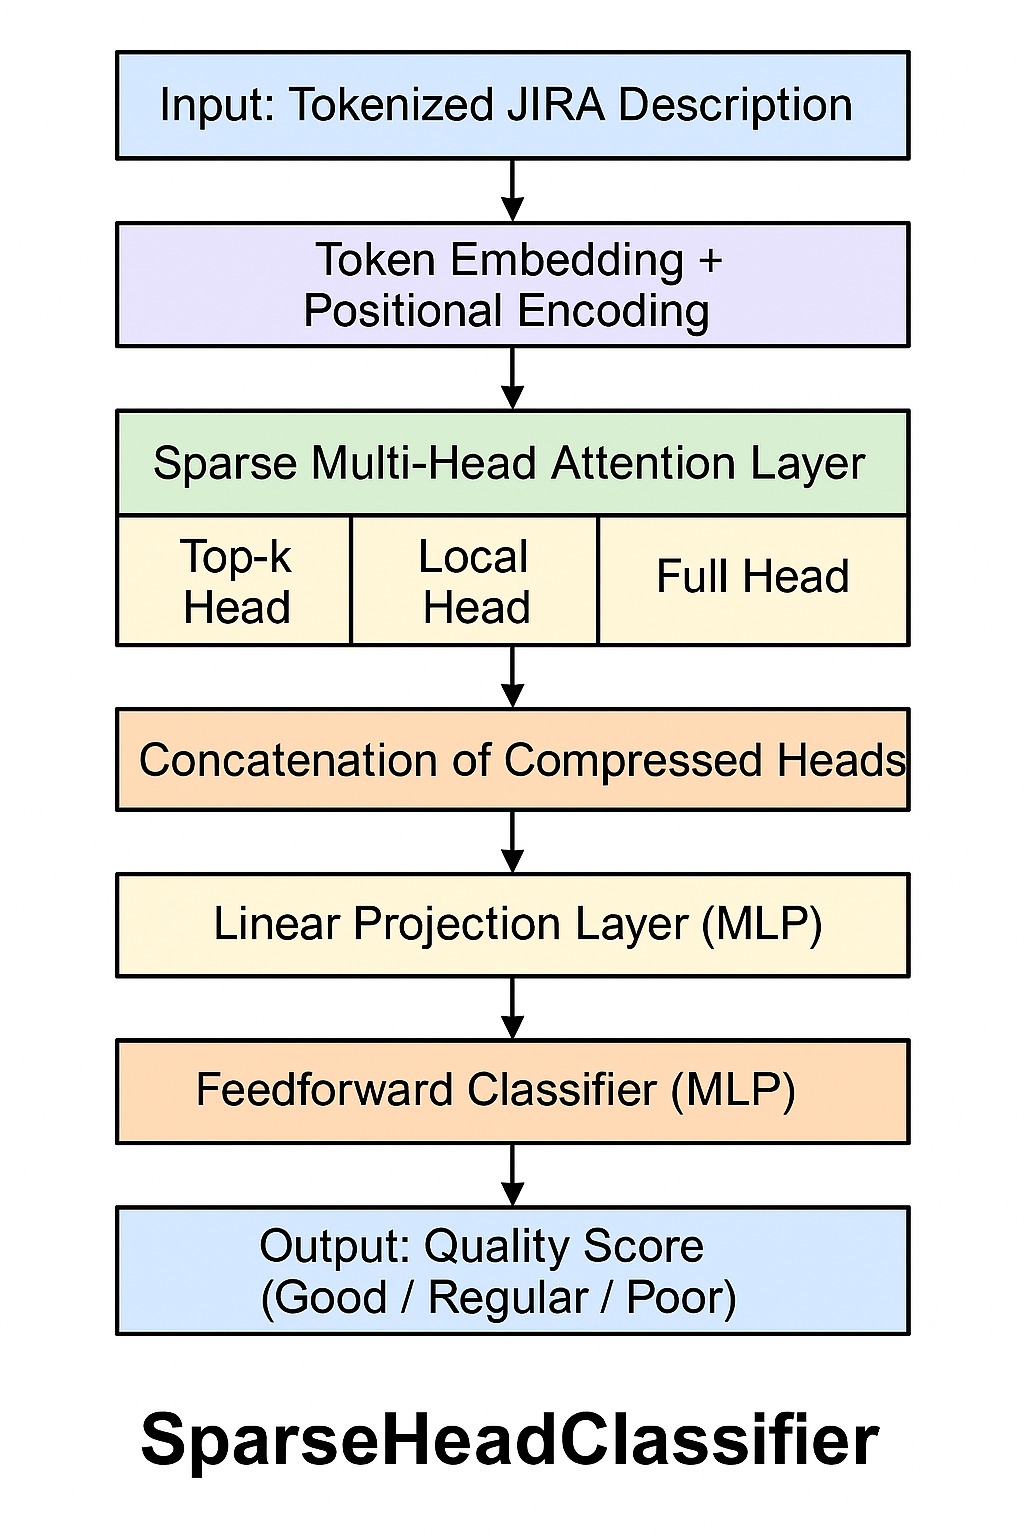

In [1]:
import pandas as pd

# URL al archivo raw en GitLab
url = "/content/drive/MyDrive/autozone/AutoZone JIRA 2025-07-01T21_24_24-0500(in).csv"

# Leer el archivo CSV directamente desde GitLab
df = pd.read_csv(url)

# Mostrar las primeras filas para verificar
print(df.head())

                                             Summary Issue key  Issue id  \
0  Verify Autozoner SelfCheckout Actions Courtesy...  QR-26591    746670   
1            Verify GapToEarn Qualifies No AzRewards  QR-26590    746697   
2  Verify Login to Autozone Rewards account with ...  QR-26589    746647   
3  Verify Age Restricted Modal not shown by addin...  QR-26588    746612   
4  Verify SaveCart button is enabled by opening A...  QR-26587    746719   

  Issue Type                      Labels                    Labels.1  \
0       Test  POS_Regression_Handover_II                    Reviewed   
1       Test  POS_Regression_Handover_II                    Reviewed   
2       Test  POS_Regression_Handover_II                    Reviewed   
3       Test        AgilityJIRASyncissue  POS_Regression_Handover_II   
4       Test  POS_Regression_Handover_II                    Reviewed   

                         Labels.2                        Labels.3 Labels.4  \
0  Standard_Regression_Automatio

In [2]:
headers = list(df.columns)
print(headers)

['Summary', 'Issue key', 'Issue id', 'Issue Type', 'Labels', 'Labels.1', 'Labels.2', 'Labels.3', 'Labels.4', 'Labels.5', 'Description', 'Custom field (API Environment)', 'Custom field (ARS #)', 'Custom field (ARS Title)', 'Custom field (Agility URL)', 'Custom field (Application Name)', 'Custom field (Business Process)', 'Custom field (Classifications)', 'Custom field (Connection String)', 'Custom field (Country)', 'Custom field (Database Name)', 'Custom field (Difference between versions)', 'Custom field (Environment)', 'Custom field (Epic Link)', 'Custom field (Expected Outcome)', 'Custom field (Expected Output)', 'Custom field (Experience Type)', 'Custom field (Feature/Menu)', 'Custom field (Feature/Menu).1', 'Custom field (Flagged)', 'Custom field (Hardware)', 'Custom field (Issue Owner)', 'Custom field (Manual Test Case)', 'Custom field (Original story points)', 'Custom field (PO Review)', 'Custom field (Parent Link)', 'Custom field (Platform/Framework)', 'Custom field (Pre-Deploym

In [3]:
columns_to_keep = [
    'Issue key',
    'Summary',
    'Issue Type',
    'Labels',
    'Labels.1', 'Labels.2', 'Labels.3', 'Labels.4', 'Labels.5',
    'Description',
    'Custom field (Expected Outcome)',
    'Custom field (Environment)',
    'Custom field (Severity)',
    'Custom field (Test Identifier)',
    'Custom field (Zephyr Teststep)',
    'Sprint',
    'Custom field (Team)'
]

# Filtrar solo las columnas que existen en el archivo (para evitar errores si faltan algunas)
columns_present = [col for col in columns_to_keep if col in df.columns]

# Crear DataFrame reducido
df_reduced = df[columns_present]

# Verificar resultado
print("\nColumnas mantenidas:")
print(df_reduced.columns)

print("\nPrimeras filas del DataFrame limpio:")
print(df_reduced.head())


Columnas mantenidas:
Index(['Issue key', 'Summary', 'Issue Type', 'Labels', 'Labels.1', 'Labels.2',
       'Labels.3', 'Labels.4', 'Labels.5', 'Description',
       'Custom field (Expected Outcome)', 'Custom field (Environment)',
       'Custom field (Severity)', 'Custom field (Test Identifier)',
       'Custom field (Zephyr Teststep)', 'Sprint', 'Custom field (Team)'],
      dtype='object')

Primeras filas del DataFrame limpio:
  Issue key                                            Summary Issue Type  \
0  QR-26591  Verify Autozoner SelfCheckout Actions Courtesy...       Test   
1  QR-26590            Verify GapToEarn Qualifies No AzRewards       Test   
2  QR-26589  Verify Login to Autozone Rewards account with ...       Test   
3  QR-26588  Verify Age Restricted Modal not shown by addin...       Test   
4  QR-26587  Verify SaveCart button is enabled by opening A...       Test   

                       Labels                    Labels.1  \
0  POS_Regression_Handover_II             

In [4]:
#Limpieza de toda la información para que podamos hacer un promot con todo lo funcional
def has_meaningful_data(row):
    has_summary = pd.notna(row.get('Summary')) and str(row['Summary']).strip() != ""
    has_description = pd.notna(row.get('Description')) and str(row['Description']).strip() != ""
    has_expected = pd.notna(row.get('Custom field (Expected Outcome)')) and str(row['Custom field (Expected Outcome)']).strip() != ""
    has_labels = any(pd.notna(row.get(label)) and str(row[label]).strip() != "" for label in ['Labels', 'Labels.1', 'Labels.2', 'Labels.3', 'Labels.4', 'Labels.5'])
    return has_summary and (has_description or has_expected or has_labels)

# Aplica el filtro
df_filtered = df_reduced[df_reduced.apply(has_meaningful_data, axis=1)]

# Verifica cuántas filas quedaron
print(f"Total de casos antes de limpiar: {len(df_reduced)}")
print(f"Total de casos con información completa: {len(df_filtered)}")

Total de casos antes de limpiar: 120
Total de casos con información completa: 120


In [5]:
# Construye los prompts para los primeros 10 casos
prompt_parts = []
for idx, row in df_filtered.head(10).iterrows():
    prompt_parts = []

    # Summary y Description primero
    if pd.notna(row['Summary']) and str(row['Summary']).strip():
        prompt_parts.append(f"Summary: {row['Summary']}")
    if pd.notna(row.get('Description')) and str(row['Description']).strip():
        prompt_parts.append(f"Description: {row['Description']}")

    # Labels
    labels = [str(row[label]) for label in ['Labels', 'Labels.1', 'Labels.2', 'Labels.3', 'Labels.4', 'Labels.5'] if pd.notna(row.get(label)) and str(row[label]).strip()]
    if labels:
        prompt_parts.append(f"Labels: {', '.join(labels)}")

    # Otros campos contextuales clave
    for field in ['Custom field (Expected Outcome)', 'Custom field (Environment)', 'Custom field (Severity)', 'Custom field (Test Identifier)', 'Custom field (Zephyr Teststep)', 'Sprint', 'Custom field (Team)']:
        if pd.notna(row.get(field)) and str(row[field]).strip():
            # Mostrar el nombre del campo entre paréntesis si es "Custom field (...)"
            pretty_name = field.split('(')[-1].strip(')') if '(' in field else field
            prompt_parts.append(f"{pretty_name}: {row[field]}")

    prompt = "Genera un caso de prueba con los siguientes datos:\n" + "\n".join(prompt_parts)
    prompt_parts.append(prompt_parts)
    print(f"\n--- Prompt #{idx + 1} ---")
    print(prompt)



--- Prompt #1 ---
Genera un caso de prueba con los siguientes datos:
Summary: Verify Autozoner SelfCheckout Actions Courtesy Discount with GreyShirt password
Labels: POS_Regression_Handover_II, Reviewed, Standard_Regression_Automation
Test Identifier: Automated_Selenium

--- Prompt #2 ---
Genera un caso de prueba con los siguientes datos:
Summary: Verify GapToEarn Qualifies No AzRewards
Description: Verify Gap To Earn section is displayed with the SCO changes and Sign-In button is working as expected
Labels: POS_Regression_Handover_II, Reviewed, Standard_Regression_Automation
Test Identifier: Automated_Selenium

--- Prompt #3 ---
Genera un caso de prueba con los siguientes datos:
Summary: Verify Login to Autozone Rewards account with invalid Rewards Id for Espanol
Description: Verify Login to Autozone Rewards account with invalid Rewards Id for Espanol
Labels: POS_Regression_Handover_II, Reviewed, Standard_Regression_Automation
Test Identifier: Automated_Selenium

--- Prompt #4 ---
Ge

In [6]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [7]:
import torch
import torch.nn as nn
import math

#Section 1: Tokenization and Initial Representation
This section defines how raw text is converted into a sequence of vectors as input to the model.

Let the input text be a sequence of words:

$$
x = [w_1, w_2, \dots, w_n]
$$

where $w_i$ represents the $i$-th word in the input.


Each word $w_i$ is mapped to an index $t_i$ from the vocabulary $V$ using a tokenizer:

$$
t_i = \text{Tokenizer}(w_i), \quad t_i \in \{1, 2, \dots, |V|\}
$$

The full sequence becomes:

$$
\mathbf{t} = [t_1, t_2, \dots, t_n]
$$


Each token index $t_i$ is converted to a dense vector of dimension $d$ via an embedding matrix $E \in \mathbb{R}^{|V| \times d}$:

$$
x_i = E[t_i] \in \mathbb{R}^d
$$

The entire tokenized input is then represented as a matrix:

$$
X = [x_1, x_2, \dots, x_n]^\top \in \mathbb{R}^{n \times d}
$$


To capture word order, a positional encoding $P_i$ is added to each embedding:

$$
x_i^{\text{pos}} = x_i + P_i
$$

So the final input to the model is:

$$
X_{\text{pos}} = X + P \in \mathbb{R}^{n \times d}
$$


In [8]:
import math
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]


##  TokenEmbedding with WordPiece – Mathematical Explanation

The `TokenEmbedding` class transforms sequences of token indices (obtained via WordPiece tokenization) into dense vectors, which are used as input for models like Transformers.

---

###  Mathematical Definition

Let:

- $V$: the vocabulary size of the WordPiece tokenizer  
- $d_{\text{model}}$: the embedding dimension

The embedding layer is a trainable matrix:

$$
E \in \mathbb{R}^{V \times d_{\text{model}}}
$$

Each token index $i$ corresponds to a subword and is associated with a dense vector:

$$
\text{embedding}(i) = E_i \in \mathbb{R}^{d_{\text{model}}}
$$

---

###  Input

The input is a tensor:

$$
x \in \mathbb{N}^{B \times T}
$$

Where:

- $B$: batch size (number of input prompts)  
- $T$: sequence length (number of tokens per prompt)

---

###  Operation

Each token index $x_{b,t}$ is replaced with the corresponding embedding vector:

$$
x_{b,t} \mapsto E_{x_{b,t}} \in \mathbb{R}^{d_{\text{model}}}
$$

This is applied to all tokens in all sequences of the batch.

---

###  Output

The output is a 3D tensor:

$$
\text{output} \in \mathbb{R}^{B \times T \times d_{\text{model}}}
$$

Each token has been converted into a vector of size $d_{\text{model}}$, preserving the original batch and sequence structure.

---


In [10]:
import torch
import torch.nn as nn
from transformers import BertTokenizer

class PromptTensorizer(nn.Module):
    def __init__(self, d_model=64, pretrained_tokenizer="bert-base-uncased"):
        super().__init__()
        self.d_model = d_model

        # Load a pre-trained WordPiece tokenizer (e.g., BERT's)
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_tokenizer)

        # Embedding layer for token IDs
        self.embedding = nn.Embedding(self.tokenizer.vocab_size, d_model)

        # Positional encoding layer (sinusoidal or learnable)
        self.pos_encoding = PositionalEncoding(d_model)

    def forward(self, prompts):
        """
        Args:
            prompts (list of str): input text prompts, e.g., ["Verify checkout", "Check rewards"]

        Returns:
            Tensor: encoded tensor of shape (batch_size, seq_len, d_model)
        """

        # Tokenize input prompts using WordPiece (with padding/truncation)
        tokens = self.tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            add_special_tokens=True  # adds [CLS], [SEP]
        )

        # Convert token IDs to embeddings
        input_ids = tokens["input_ids"]  # shape: (batch_size, seq_len)
        embeddings = self.embedding(input_ids)  # shape: (batch_size, seq_len, d_model)

        # Add positional encoding
        encoded = self.pos_encoding(embeddings)  # shape: (batch_size, seq_len, d_model)

        return encoded


In [11]:
model = PromptTensorizer(d_model=64)
prompts = ["Verify checkout", "Check user rewards"]
out = model(prompts)

print(out.shape)  # (batch_size=2, seq_len, d_model=64)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

torch.Size([2, 5, 64])


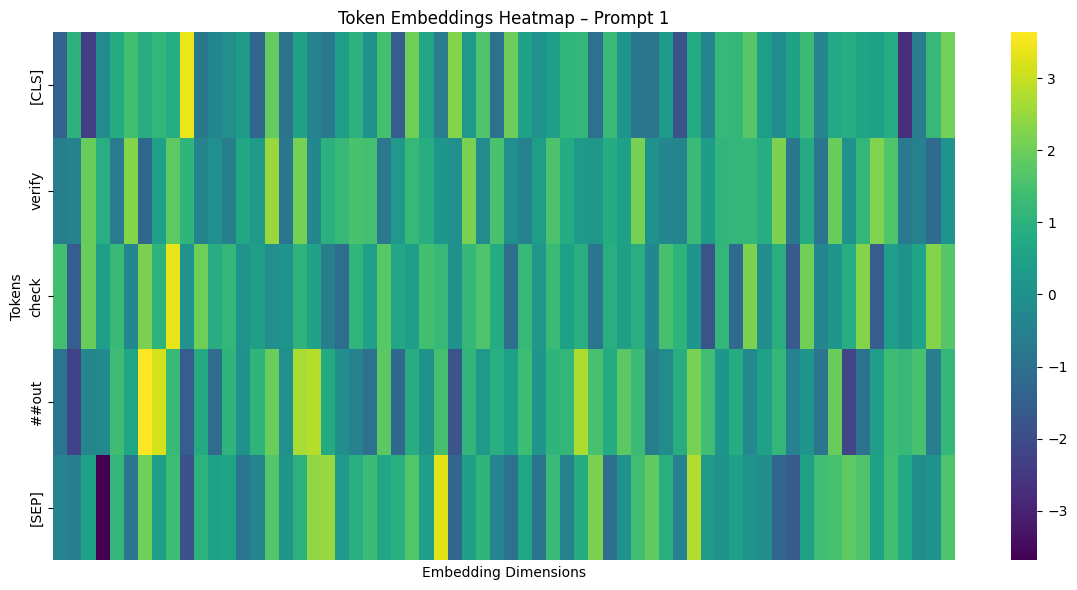

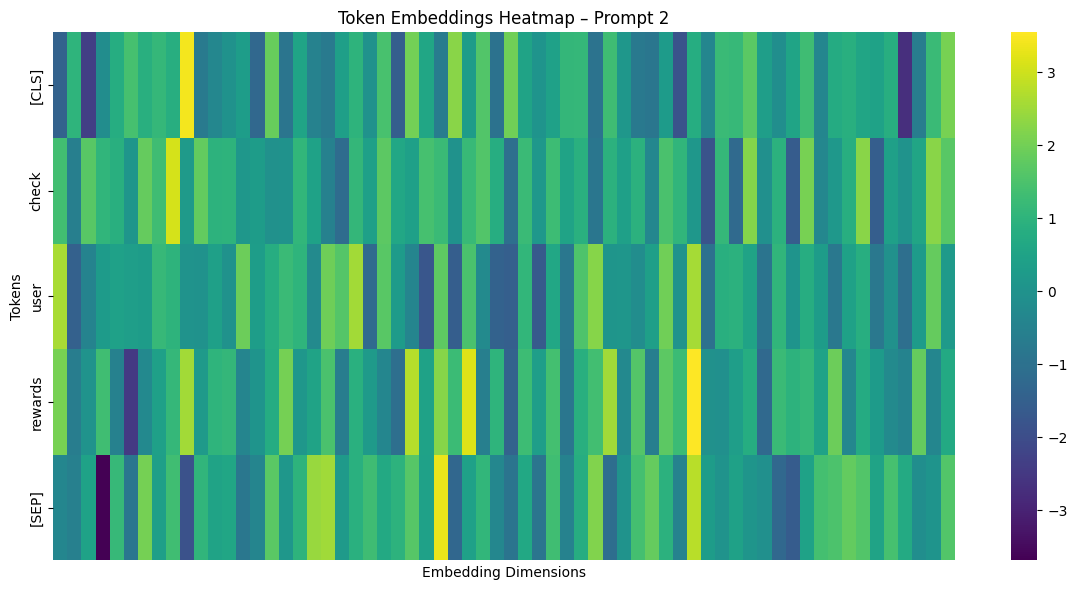

In [12]:
# Convert to NumPy
embeddings_np = out.detach().numpy()

# Plot heatmaps for each prompt
for i, prompt in enumerate(prompts):
    # Get token strings
    token_ids = model.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)["input_ids"][0]
    tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

    # Get embedding of the i-th prompt
    emb = embeddings_np[i]  # shape: (seq_len, d_model)

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(emb, xticklabels=False, yticklabels=tokens, cmap="viridis")
    plt.title(f"Token Embeddings Heatmap – Prompt {i+1}")
    plt.xlabel("Embedding Dimensions")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This module compresses the output after multi-head attention using a small feedforward network
class AttentionCompressor(nn.Module):
    def __init__(self, d_model, compression_ratio=0.5):
        super().__init__()
        hidden_dim = int(d_model * compression_ratio)
        self.proj = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.proj(x)  # Output shape: (batch_size, sequence_length, d_model)

# Multi-head attention module with different kernel functions per head and an integrated compressor
class MultiKernelMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, kernel_types, dropout=0.1, compression_ratio=0.5):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        assert len(kernel_types) == num_heads, "You must provide one kernel type per head"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # dimension per head
        self.kernel_types = kernel_types

        # Dropout applied to attention weights
        self.dropout = nn.Dropout(dropout)

        # Linear projections for queries, keys, and values
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Final output projection after combining all heads
        self.W_o = nn.Linear(d_model, d_model)

        # Compression layer after combining all head outputs
        self.compressor = AttentionCompressor(d_model, compression_ratio)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Project input into multi-head query, key, and value
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Store attention weights and head outputs
        attn_weights = []
        attn_outputs = []

        # Process each head separately using its corresponding kernel
        for h in range(self.num_heads):
            q = Q[:, h, :, :]  # shape: (batch_size, seq_len, d_k)
            k = K[:, h, :, :]
            v = V[:, h, :, :]

            scores = self.kernel_attention(q, k, self.kernel_types[h])
            weights = F.softmax(scores, dim=-1)
            weights = self.dropout(weights)
            output = torch.matmul(weights, v)  # shape: (batch_size, seq_len, d_k)

            attn_weights.append(weights.unsqueeze(1))  # keep head dimension
            attn_outputs.append(output.unsqueeze(1))   # keep head dimension

        # Combine attention weights and outputs from all heads
        attn_weights = torch.cat(attn_weights, dim=1)   # shape: (batch_size, num_heads, seq_len, seq_len)
        attn_outputs = torch.cat(attn_outputs, dim=1)   # shape: (batch_size, num_heads, seq_len, d_k)

        # Concatenate all heads into a single tensor
        out = attn_outputs.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # Apply compression to reduce redundant information
        out = self.compressor(out)

        # Final projection layer
        out = self.W_o(out)

        # Analyze attention metrics (entropy, sparsity, etc.)
        metrics = self.analyze_attention(attn_weights)

        return out, metrics, attn_weights

    def kernel_attention(self, q, k, kernel_type):
        if kernel_type == 'dot':
            # Scaled dot-product attention
            return torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
        elif kernel_type == 'poly':
            # Polynomial kernel: (q·k + 1)^2
            return (torch.matmul(q, k.transpose(-2, -1)) + 1).pow(2)
        elif kernel_type == 'laplacian':
            # Laplacian kernel: -L1 distance
            return -torch.cdist(q, k, p=1)
        elif kernel_type == 'rbf':
            # Radial basis function (Gaussian) kernel: -L2 distance squared
            return -torch.cdist(q, k, p=2).pow(2)
        else:
            raise ValueError(f"Unknown kernel type: {kernel_type}")

    def analyze_attention(self, attn_weights):
        return {
            "entropy": self.attention_entropy(attn_weights),
            "sparsity": self.attention_sparsity(attn_weights),
            "similarity": self.head_similarity(attn_weights),
            "approx_rank": self.attention_rank(attn_weights)
        }

    def attention_entropy(self, attn_weights):
        # Computes entropy for each attention map
        return -(attn_weights * torch.log(attn_weights + 1e-9)).sum(dim=-1).mean(dim=-1)

    def attention_sparsity(self, attn_weights, threshold=0.01):
        # Measures how many elements are below a threshold (sparse)
        return (attn_weights < threshold).float().mean(dim=-1).mean(dim=-1)

    def head_similarity(self, attn_weights):
        # Computes cosine similarity between each pair of heads
        batch_size, num_heads, seq_len, _ = attn_weights.shape
        similarities = []
        for b in range(batch_size):
            for i in range(num_heads):
                for j in range(i + 1, num_heads):
                    head_i = attn_weights[b, i].flatten()
                    head_j = attn_weights[b, j].flatten()
                    sim = F.cosine_similarity(head_i, head_j, dim=0)
                    similarities.append(sim)
        return torch.stack(similarities).mean() if similarities else torch.tensor(0.0, device=attn_weights.device)

    def attention_rank(self, attn_weights, threshold=0.9):
        # Estimates the approximate rank using singular values
        ranks = []
        for b in range(attn_weights.size(0)):
            for h in range(attn_weights.size(1)):
                A = attn_weights[b, h]
                S = torch.linalg.svdvals(A)
                S_norm = S / S.sum()
                cum_sum = torch.cumsum(S_norm, dim=0)
                rank = (cum_sum < threshold).sum().item() + 1
                ranks.append(rank)
        return torch.tensor(ranks).float().mean()


In [ ]:
class TextQualityClassifier(nn.Module):
    def __init__(self, d_model, num_heads, kernel_layers, num_classes=3, dropout=0.1, compression_ratio=0.5):
        super().__init__()
        self.layers = nn.ModuleList()
        for kernel_types in kernel_layers:
            self.layers.append(
                MultiKernelMultiHeadAttention(
                    d_model=d_model,
                    num_heads=num_heads,
                    kernel_types=kernel_types,
                    dropout=dropout,
                    compression_ratio=compression_ratio
                )
            )

        # Pooling: average over sequence dimension
        self.pooling = nn.AdaptiveAvgPool1d(1)

        # Final classifier: outputs logits for each class
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: shape (batch_size, sequence_length, d_model)
        all_metrics = []

        for layer in self.layers:
            x, metrics, _ = layer(x)
            all_metrics.append(metrics)

        # Rearrange: (B, T, D) -> (B, D, T) for pooling
        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)  # shape: (B, D)

        logits = self.classifier(x)  # shape: (B, num_classes)
        return logits, all_metrics
